In [52]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions


from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

# ------------------------------------------------------------------------------------------------
def get_vars(dirname, y_start, y_end, ind_incomingA, ind_incomingB):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y = slice(y_start, y_end, None)
    x = slice(ind_incomingA, ind_incomingB, None)
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    print('files')
            
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        depthu = dsU.variables['depthu'][:]
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        vomecrty0 = dsV.variables['vomecrty'][:,:,y,x]
        print('V')
        sometauy = dsV.variables['sometauy'][:,0,0]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]
    print('masks')
     
    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux),1, 1, 1))
    
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vozocrtx, sozotaux, vomecrty, sometauy, depthu

In [4]:
bfile = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
bathy = bfile['Bathymetry'][:]
xs = np.arange(bathy.shape[-1])
ys = np.arange(bathy.shape[-2])
ind_axis = int(bathy.shape[-1] / 2)
ind_rim = 145
ind_incomingA = ind_rim + 15
ind_incomingB = ind_incomingA + 5
y_start = 80
y_end = 100

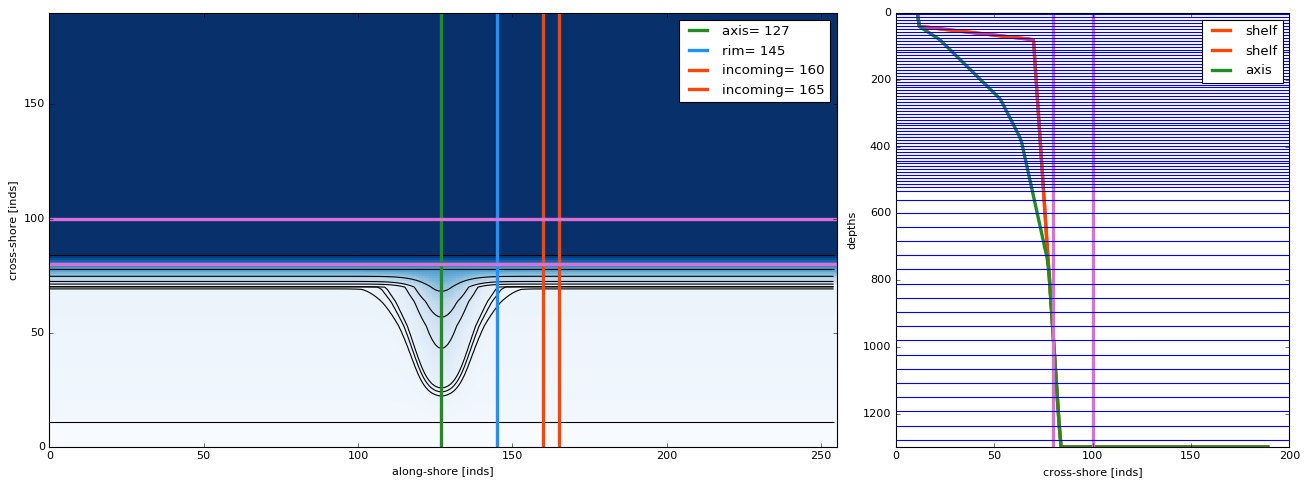

In [8]:
lw=3; fig = plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1, 2,width_ratios=[2, 1], wspace=0.1)
ax1 = plt.subplot(gs[0]); ax2 = plt.subplot(gs[1])
ax2.plot(ys, bathy[:, ind_incomingA], c='orangered', linewidth=lw, label='shelf')
ax2.plot(ys, bathy[:, ind_incomingB], c='orangered', linewidth=lw, label='shelf')
ax2.plot(ys, bathy[:, ind_axis], c='forestgreen', linewidth=lw, label='axis')
ax2.set_ylim([1300,0])
ax2.set_ylabel('depths')
ax2.set_xlabel('cross-shore [inds]')
ax2.axvline(y_start, c='orchid', linewidth=lw)
ax2.axvline(y_end, c='orchid', linewidth=lw)
ax2.legend()

ax1.contour(xs, ys, bathy, levels = [0,80,90,100,200,300,500,800,1299],colors='k')
ax1.pcolormesh(bathy, cmap=cm.Blues)
ax1.set_ylabel('cross-shore [inds]')
ax1.set_xlabel('along-shore [inds]')
ax1.axvline(ind_axis, c='forestgreen', linewidth=lw, label='axis= '+str(ind_axis))
ax1.axvline(ind_rim, c='dodgerblue', linewidth=lw, label='rim= '+str(ind_rim))
ax1.axvline(ind_incomingA, c='orangered', linewidth=lw, label='incoming= '+str(ind_incomingA))
ax1.axvline(ind_incomingB, c='orangered', linewidth=lw, label='incoming= '+str(ind_incomingB))
ax1.axhline(y_start, c='orchid', linewidth=lw)
ax1.axhline(y_end, c='orchid', linewidth=lw)
ax1.legend()

for i in depthu:
    ax2.axhline(i)

In [7]:
depth_ind = 9
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

vozocrtx, sozotaux, vomecrty, sometauy, depthu = get_vars(dirname, y_start, y_end, ind_incomingA, ind_incomingB)

files
U
V
masks


In [40]:
def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

In [57]:
avgU = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)
print(avgU.shape, vozocrtx.shape)

avgV = np.mean(np.mean(vomecrty, axis=-1), axis=-1)
print(avgV.shape, vomecrty.shape)

(480, 80) (480, 80, 20, 5)
(480, 80) (480, 80, 20, 5)


In [41]:
speeds_all = np.ones([len(sozotaux), 80, y_end-y_start-1, ind_incomingB-ind_incomingA-1])

for dep_ind in np.arange(80):
    for time_ind in np.arange(480):
        speeds = get_speeds(vozocrtx, vomecrty, dep_ind, time_ind, 1)
        speeds_all[time_ind, dep_ind, :, :] = speeds

In [58]:
avgS = np.mean(np.mean(speeds_all, axis=-1), axis=-1)
print(avgS.shape, speeds_all.shape)

(480, 80) (480, 80, 19, 4)


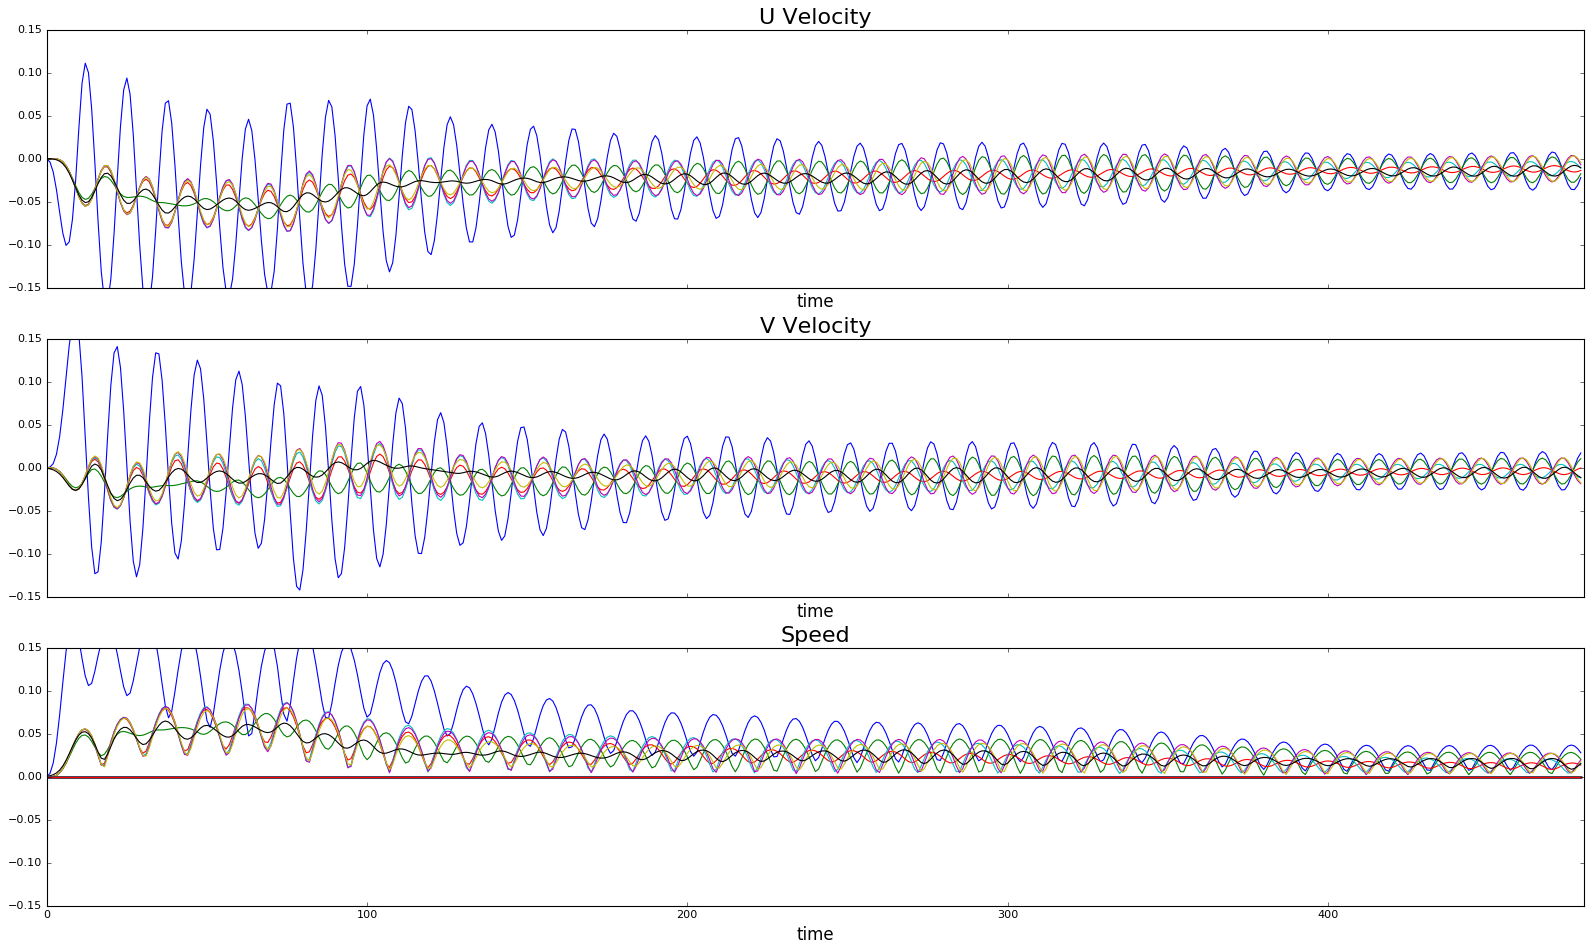

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
for dep_ind in np.arange(80):
    ax1.plot(avgU[:, dep_ind], label = str(dep_ind))
    ax2.plot(avgV[:, dep_ind], label = str(dep_ind))
    ax3.plot(avgS[:, dep_ind], label = str(dep_ind))

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlabel('time', fontsize=15)
    ax.set_title(ttl, fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.15, 0.15])
fig.tight_layout(h_pad=0.5)

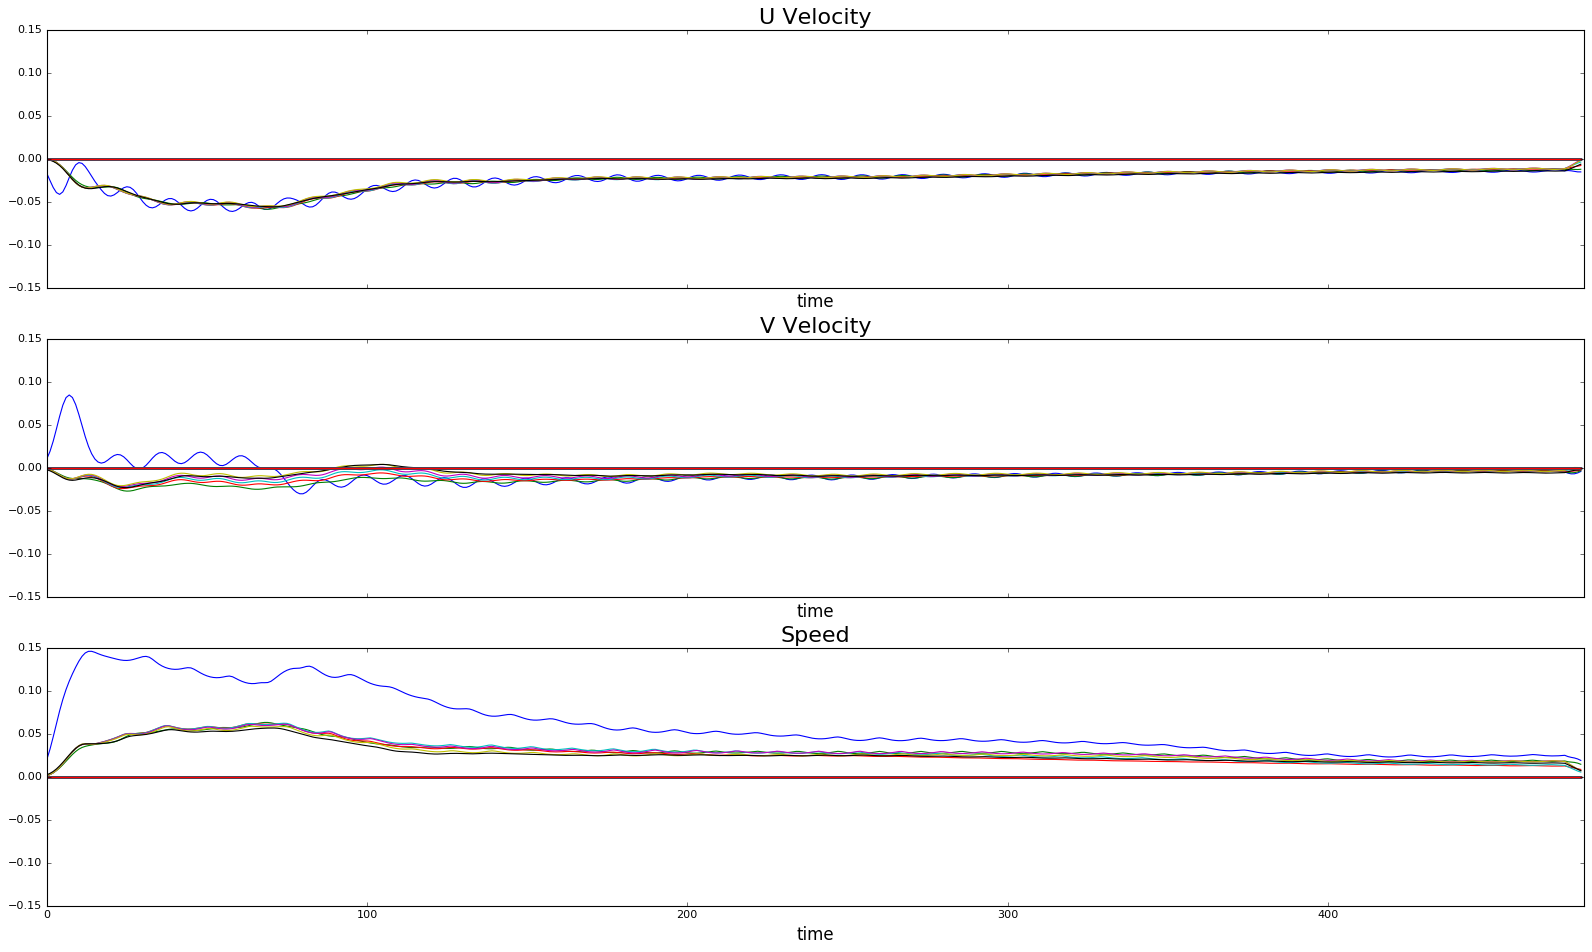

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20, 12), sharex=True)
for dep_ind in np.arange(80):
    n=12
    ax1.plot(general_functions.smooth(avgU[:, dep_ind],n), label = str(dep_ind))
    ax2.plot(general_functions.smooth(avgV[:, dep_ind],n), label = str(dep_ind))
    ax3.plot(general_functions.smooth(avgS[:, dep_ind],n), label = str(dep_ind))

for ax, ttl in zip([ax1, ax2, ax3], ['U Velocity','V Velocity','Speed']):
    ax.set_xlabel('time', fontsize=15)
    ax.set_title(ttl, fontsize=20)
    ax.set_xlim([0, 480])
    ax.set_ylim([-0.15, 0.15])
fig.tight_layout(h_pad=0.5)